In [43]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [44]:
raw_data = np.loadtxt('EEG_feature.txt')
# print(raw_data.shape)
subject_video_label = np.loadtxt('subject_video.txt')
#print(subject_video_label[:,0])
valence_arousal_label = np.loadtxt('valence_arousal_label.txt')

In [45]:
pca = PCA(n_components=2)
out = pca.fit_transform(raw_data)
# print(out.shape)
# print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

0.662445447924595


In [46]:
class cluster_eval(object):
    def _dist(self, x, y):
        return np.sum((x - y) ** 2) ** 0.5
    def __init__(self, raw_data):
        self.raw_data = raw_data
        self.dis = [[self._dist(raw_data[i], raw_data[j]) for j in range(i)] for i in range(len(raw_data))]
    def eval(self, label, centers, clusters):
        self.clu_label = [[] for i in range(clusters)]
        for i in range(len(label)):
            self.clu_label[label[i]].append(i)
        centers = [np.mean(self.raw_data[self.clu_label[i]], axis=0) for i in range(clusters)]
        # avg, diam
        self.clu_avg = [0 for i in range(clusters)]
        self.diam = [0 for i in range(clusters)]
        for i in range(clusters):
            clu_num = len(self.clu_label[i])
            for j in range(clu_num):
                for k in range(j):
                    jk_dis = self.dis[self.clu_label[i][j]][self.clu_label[i][k]]
                    self.clu_avg[i] += jk_dis
                    self.diam[i] = max(self.diam[i], jk_dis)
            self.clu_avg[i] *= 2 / (clu_num * (clu_num - 1))
        # dcen
        self.cen = [[self._dist(centers[i], centers[j]) for j in range(i)] for i in range(clusters)]
        # dmin
        self.dmin = [[j for j in i] for i in self.cen]
        for i in range(clusters):
            for j in range(i):
                for k in self.clu_label[i]:
                    for l in self.clu_label[j]:
                        self.dmin[i][j] = min(self.dmin[i][j], self.dis[max(k, l)][min(k, l)])
        # DBI
        self.DBI = sum(max(self.cen[max(i, j)][min(i, j)] for j in list(range(i)) + list(range(i + 1, clusters))) for i in range(clusters)) / clusters
        # print(self.DBI)
        # Dunn
        self.Dunn = min(min(i) for i in self.dmin[1:]) / max(self.diam)
        # print(self.Dunn)

In [34]:
for n_clusters in [2]:#, 3, 4, 5, 6, 8, 10, 32, 38]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeansout = kmeans.fit(raw_data)
    e = cluster_eval(raw_data)
    e.eval(kmeansout.labels_, kmeansout.cluster_centers_, n_clusters)
    # print(n_clusters, e.DBI, e.Dunn)

In [8]:
for n_clusters in [2, 3, 4, 5, 6, 8, 10, 32]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, init='random')
    kmeansout = kmeans.fit(raw_data)
    e = cluster_eval(raw_data)
    e.eval(kmeansout.labels_, kmeansout.cluster_centers_, n_clusters)
    print(n_clusters, e.DBI, e.Dunn)

2 11.96415880057959 0.06445432577653755
3 13.050998228978061 0.06836927195715756
4 14.56934977532082 0.07353152299031981
5 22.827039192118047 0.06599536810054239
6 22.53352523127153 0.07698826038993817
8 23.286835603050353 0.10264918722812263
10 23.316332832325283 0.10219677382317006
32 23.748717193911787 0.12387311489577149


In [37]:
for covariance_type in ['full', 'tied', 'diag', 'spherical']:
    n_clusters = 6
    gm = GaussianMixture(n_components=n_clusters, covariance_type=covariance_type)
    gmout = gm.fit_predict(raw_data)
    e = cluster_eval(raw_data)
    e.eval(gmout, None, n_clusters)
    print(covariance_type, e.DBI, e.Dunn)

full 22.47773107988422 0.09831820651369301
tied 23.670231282669295 0.14666086436496323
diag 23.230354582341718 0.07905186911790175
spherical 23.505452324345203 0.08163001651971362


In [39]:
def jaccard(clu_label, label):
    n = len(clu_label)
    a = 0
    bc = 0
    for i in range(n):
        for j in range(i):
            if clu_label[i] == clu_label[j] and label[i] == label[j]:
                a += 1
            if clu_label[i] != clu_label[j] and label[i] == label[j]:
                bc += 1
            if clu_label[i] == clu_label[j] and label[i] == label[j]:
                bc += 1
    return a / (a + bc)

In [47]:
kmeans = KMeans(n_clusters=32, random_state=0)
kmeansout = kmeans.fit(raw_data).labels_
subject_label = subject_video_label[:, 0]
video_label = subject_video_label[:, 1]
print(jaccard(kmeansout, subject_label))
print(jaccard(kmeansout, video_label))

0.4533038469950667
0.011226523974399329


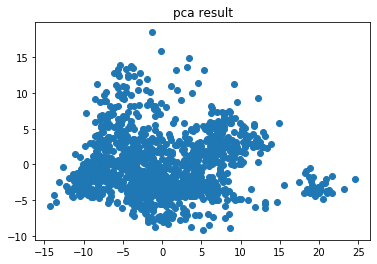

In [48]:
plt.title('pca result')
plt.scatter(out[..., 0], out[..., 1])